In [2]:
import os
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import pandas as pd
import random
import re
import zhconv
import pickle
import matplotlib.pyplot as plt

In [3]:
# Load data
data = defaultdict(dict)
categories = ['易藏', '医藏', '艺藏', '史藏', '佛藏', '集藏', '诗藏', '子藏', '儒藏', '道藏']
pat = re.compile('[^\S\n]|[（）【】□)(○\[\]—…#─■·<>［］}{◎│｜\-●*〗〖〕〔０]')
for cat in tqdm(categories):
    for root, dirs, files in os.walk(os.path.join("daizhige", cat)):
        for file in files:
            if file.endswith('.txt'):
                path = os.path.join(root, file)
                with open(path) as f:
                    text = f.read()
                    # 去空格，符号
                    text = re.sub(pat, '', text)
                    data[cat][path] = text

In [4]:
# 转简体
data1 = defaultdict(dict)
for cat, files in tqdm(data.items()):
    for path, text in tqdm(files.items(), leave=False):
        text = zhconv.convert(text, 'zh-hans')
        # 拆分多行，去空行
        lines = list(filter(lambda l: l, text.split('\n')))
        data1[cat][path] = lines

In [5]:
# Data statistics
def data_stat(data):
    df = pd.DataFrame([[cat,
               len(files),                                                             # 文章数
               sum([len(lines) for _, lines in files.items()]),                        # 段落数
               sum([sum([len(line) for line in lines])for _, lines in files.items()]), # 字数
              ] for cat, files in data.items()])
    display(df)
    display(df.sum())

data_stat(data1)

,0,1,2,3
0,易藏,343,455483,32948020
1,医藏,912,1978931,100362969
2,艺藏,446,331070,17532147
3,史藏,2043,5288376,461540625
4,佛藏,5183,2304645,209847342
5,集藏,1948,3408070,337045564
6,诗藏,787,3066151,102871611
7,子藏,1463,1962567,201681814
8,儒藏,908,1361897,130134934
9,道藏,1721,721834,42702238


0    易藏医藏艺藏史藏佛藏集藏诗藏子藏儒藏道藏
1                   15754
2                20879024
3              1636667264
dtype: object

In [6]:
# filter data has punc
data2 = defaultdict(dict)
for cat, files in tqdm(data1.items()):
    for path, lines in files.items():
        filtered_lines = list(filter(lambda l: '。' in l or '.' in l, lines))
        if filtered_lines:
            data2[cat][path] = filtered_lines

In [7]:
data_stat(data2)

,0,1,2,3
0,易藏,162,125907,9329580
1,医藏,844,1023561,77757835
2,艺藏,348,47154,4794594
3,史藏,1380,1782552,228604135
4,佛藏,5042,1208326,193333481
5,集藏,853,1018999,165787606
6,诗藏,600,1523965,58684291
7,子藏,730,463878,64433945
8,儒藏,300,303976,29009764
9,道藏,1683,463366,38200985


0    易藏医藏艺藏史藏佛藏集藏诗藏子藏儒藏道藏
1                   11942
2                 7961684
3               869936216
dtype: object

In [9]:
# filter data has punc
data3 = defaultdict(dict)
for cat, files in tqdm(data2.items()):
    for path, lines in files.items():
        filtered_lines = list(filter(lambda l: '，' in l, lines))
        if filtered_lines:
            data3[cat][path] = filtered_lines

In [10]:
data_stat(data3)

,0,1,2,3
0,易藏,160,106189,7997957
1,医藏,781,623182,58398599
2,艺藏,337,42494,4617519
3,史藏,1307,1188321,165270376
4,佛藏,297,201836,21686264
5,集藏,814,968072,162467022
6,诗藏,556,1400784,51104148
7,子藏,712,361084,55148720
8,儒藏,290,244934,27636781
9,道藏,1680,402054,37209747


0    易藏医藏艺藏史藏佛藏集藏诗藏子藏儒藏道藏
1                    6934
2                 5538950
3               591537133
dtype: object

In [11]:
# 符号转换
def convert_puncs(line):
    if '"' in line:
        line = re.sub(r'"(.*?)"', r'“\1”', line)
    if "'" in line:
        line = re.sub(r"'(.*?)'", r'‘\1’', line)
    if '"' in line:
        line = line.replace('"', '')
    if "'" in line:
        line = line.replace("'", '')
    if "?" in line:
        line = line.replace("?", '？')
    if "." in line:
        line = line.replace(".", '。')
    if "!" in line:
        line = line.replace("!", '！')
    if "．" in line:
        line = line.replace("．", '。')
    if "," in line:
        line = line.replace(",", '，')
    if "﹖" in line:
        line = line.replace("﹖", '？')
    if "“”" in line:
        line = line.replace("“”", '')
    if "‘’" in line:
        line = line.replace("‘’", '')
    if "《》" in line:
        line = line.replace("《》", '')
    if "〈〉" in line:
        line = line.replace("〈〉", '')
    return line

data4 = defaultdict(dict)
for cat, files in data3.items():
    for path, lines in files.items():
        lines = list(map(convert_puncs, lines))
        data4[cat][path] = lines

In [12]:
# 统计标点符号
text = ''
for cat, files in tqdm(data4.items()):
    for path, lines in files.items():
        text += ''.join(lines)
        
counter = Counter(re.findall('[^\u4e00-\u9fa5]', text))

In [13]:
# 最多的标点符号
counter.most_common(20)

[('，', 50286404),
 ('。', 24723823),
 ('、', 4479688),
 ('：', 4349873),
 ('“', 3573743),
 ('”', 3507263),
 ('《', 1520548),
 ('》', 1518750),
 ('；', 1457653),
 ('？', 1365827),
 ('！', 671426),
 ('‘', 415327),
 ('’', 412882),
 ('1', 51792),
 ('2', 32755),
 ('〈', 27672),
 ('〉', 27543),
 ('3', 24574),
 ('4', 21681),
 ('6', 18288)]

In [14]:
# 拆分长句
max_len = 256
illegle = []
data5 = defaultdict(dict)
for cat, files in tqdm(data4.items()):
    for path, lines in files.items():
        result = []
        for line in lines:
            while len(line) > max_len:
                for punc in '。？；，':
                    idx = line.rfind(punc, 0, max_len)
                    if idx != -1:
                        break
                if idx == -1:
                    illegle.append(line)
                    line = ""
                    break
                result.append(line[:idx + 1])
                line = line[idx+1:]
            if line:
                result.append(line)
        data5[cat][path] = result

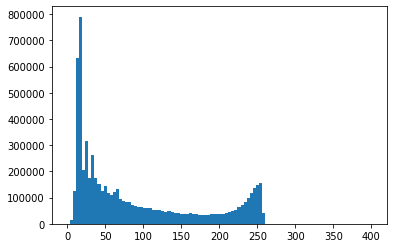

In [15]:
# 统计句子长度
def len_stat(data):
    lens = []
    for cat, files in tqdm(data.items()):
        for path, lines in files.items():
            lens.extend([len(l) for l in lines])

    plt.hist(lens, bins=100, range=(0, 400));
    
len_stat(data5)

In [16]:
len(illegle)

1145

In [17]:
data_stat(data5)

,0,1,2,3
0,易藏,160,113160,7997139
1,医藏,781,695507,58350946
2,艺藏,337,48393,4611085
3,史藏,1307,1466476,164966520
4,佛藏,297,232855,21636655
5,集藏,814,1301893,162427331
6,诗藏,556,1439601,51094705
7,子藏,712,454141,54590839
8,儒藏,290,284961,27605775
9,道藏,1680,456071,37182252


0    易藏医藏艺藏史藏佛藏集藏诗藏子藏儒藏道藏
1                    6934
2                 6493058
3               590463247
dtype: object

In [18]:
with open('data_processed.pkl', 'wb') as f:
    pickle.dump(data5, f)